<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/regression_drift_0521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)

# 준비
+ synthetic data를 만든다.


## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 해당 data는 z0 feature의 importance가 시간에 따라 감소 한다.
+ 이에 상응하여 drift 통계량은 증가한다. 

In [4]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

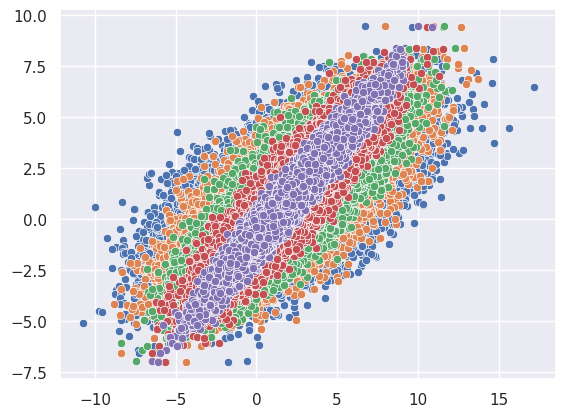

In [5]:
seed_everything()
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

+ 'z0' feature에 y와 상관관계를 떨어뜨려 importance를 점진적으로 낮춘다.

<Axes: >

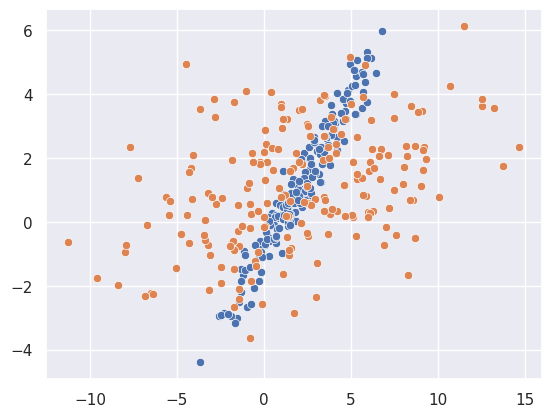

In [6]:
seed_everything(100)

for i in range(400):
    s = i*100
    # 이 부분에서 상관관계를 떨어뜨림...   
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.810444
x2    0.512920
x1    0.350373
z0    0.255009
x0    0.238650
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket의 사이즈를 200으로 잡는다. (임의)

Bucket size:200 step_size:200


100%|██████████| 200/200 [00:06<00:00, 31.80it/s]


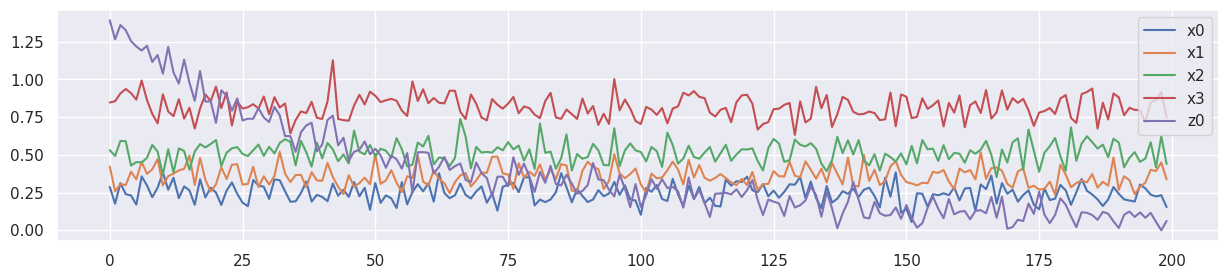

In [9]:
from tqdm import tqdm

bucket_size_array=[200] #[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.




## ks-test 

In [10]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

Bucket size:200 step_size:200


 61%|██████    | 122/200 [00:00<00:00, 1217.71it/s]<ipython-input-10-160e0953fd26>:11: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
100%|██████████| 200/200 [00:00<00:00, 1188.71it/s]


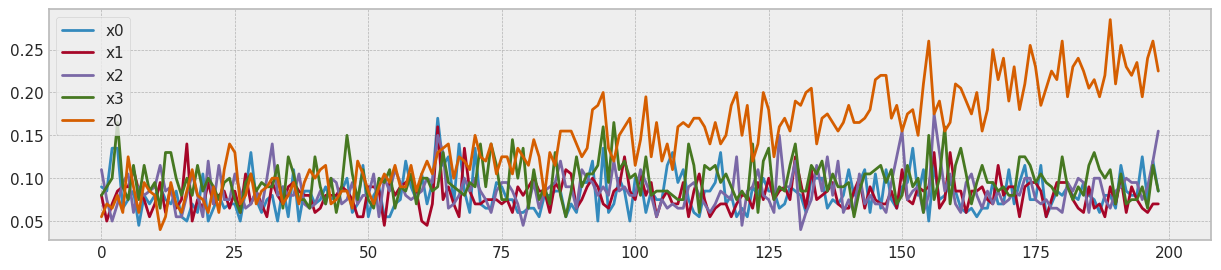

In [11]:

from tqdm import tqdm

bucket_size_array=[200] #[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:bucket_size].values,X[bk*bucket_size+bucket_size:bk*bucket_size+bucket_size+bucket_size].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 drift는 bucket의 증가에 따라, 커지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 53.89it/s]


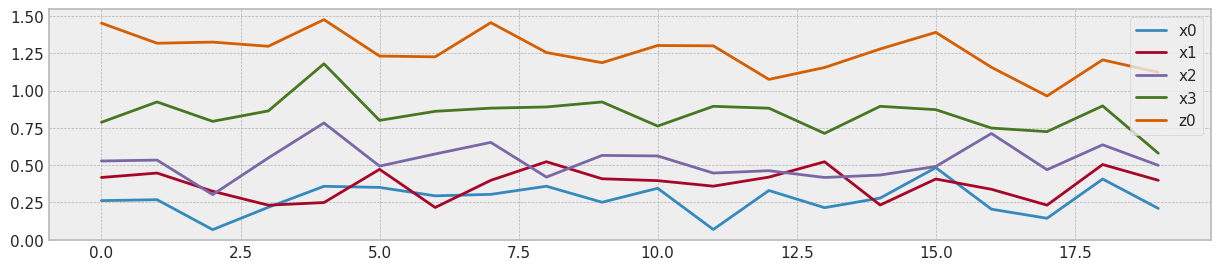

In [12]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


MSE: 0.25
RMSE: 0.50


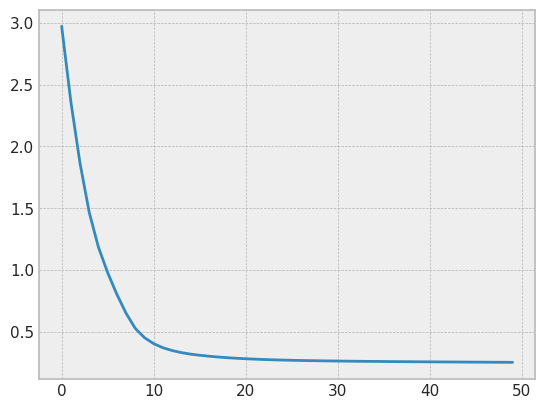

In [13]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)


print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

+ R2 측정

In [14]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9386759151685817


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 1661.83it/s]


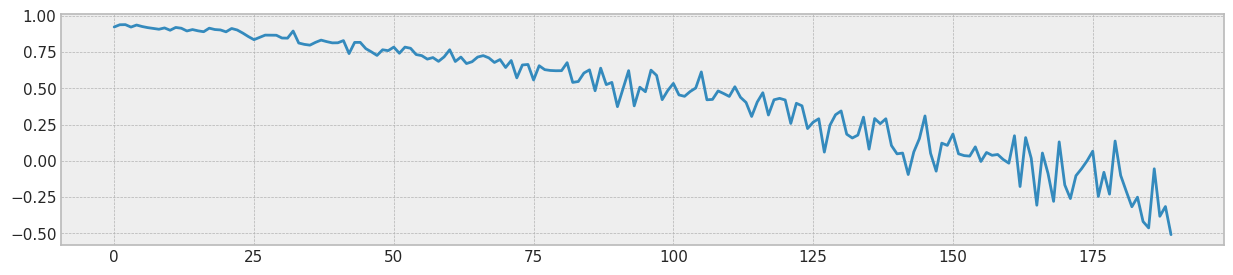

In [15]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()


+ bucket의 증가에 따라, $R^2$ 값이 점진적으로 낮아진다. (성능 열화)

# Generator + Discriminator 구조

+ Generator는 입력된 feature에 대해 z에 따라 전처리를 하는 모델
+ Discriminator는 Regression 모델
+ Generator에 control factor 'z' 를 대입하여, $R^2$가 1~0 까지 전개되도록 학습한다.

$$
L=mse(D(G(x,z=0)),y) - mse(D(G(x,z=1),y)) 
$$

+ 하지만, 뒷 부분의 항 $  - mse(D(G(x,z=1),y)) $ 는 최소화 되기 위해 값이 계속 커지기 때문에 전체 loss fucntion은 뒤 항에 지배적이 되고 실제 학습 효과가 있어야 하는 앞의 항은 학습되지 못 한다. 
+ 따라서, 뒷 부분의 항을 조절하기 위해 log(softmax(x)) 를 취하여 [-inf,0]의 범위에 있도록 한다.
+ log(softmax(x)) 가 0에 수렴 할 수록, 앞 항의 학습 효과가 발생하여 전체적인 학습이 이루어지게 된다.

$$
L=mse(D(G(x,z=0)),y) - log(softmax(mse(D(G(x,z=1),y)))) 
$$

In [16]:

# Define the Generator
class Generator(nn.Module):

    def __init__(self, input_dim):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim)
        )

    def forward(self, x,b):
        input_data = torch.cat((x,torch.zeros(x.shape[0],1) + b),1)        
        output = self.model(input_data)
        return output
 

In [17]:

# Define the regression model
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output

  2%|▏         | 1/50 [00:00<00:18,  2.59it/s]

[Epoch 0/50] [A loss: 0.246189] [B loss: 0.553206] [G loss: 0.799395]


 22%|██▏       | 11/50 [00:04<00:17,  2.19it/s]

[Epoch 10/50] [A loss: 0.197647] [B loss: 0.000125] [G loss: 0.197772]


 42%|████▏     | 21/50 [00:08<00:10,  2.84it/s]

[Epoch 20/50] [A loss: 0.205226] [B loss: 0.000028] [G loss: 0.205254]


 62%|██████▏   | 31/50 [00:11<00:06,  2.83it/s]

[Epoch 30/50] [A loss: 0.202128] [B loss: 0.000011] [G loss: 0.202138]


 82%|████████▏ | 41/50 [00:15<00:04,  2.25it/s]

[Epoch 40/50] [A loss: 0.198418] [B loss: 0.000004] [G loss: 0.198422]


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


MSE: 0.29
RMSE: 0.54


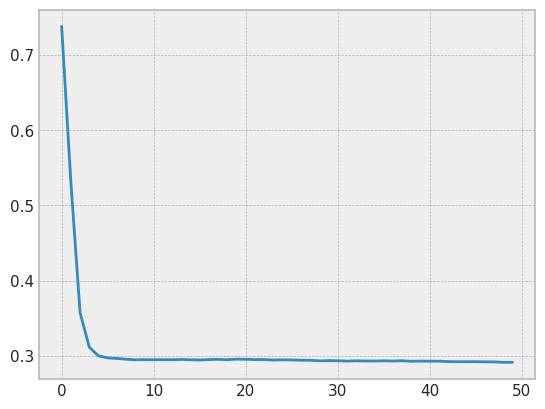

In [54]:
import copy
import torch.optim as optim

seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Initializes generator and discriminator
generator = Generator(5)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)

discriminator = Discriminator()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss function and optimizer
mse_loss = nn.MSELoss()  # mean square error
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            #  Forword Generator for z=0 
            g0 = generator(X_batch,0)

            #  Forword Generator for z=1 
            g1 = generator(X_batch,1)

            a_loss = mse_loss(discriminator(g0), y_batch.reshape(-1,1))
            #b_loss = mse_loss(discriminator(g1), shuffled_y.reshape(-1,1))
            b_loss = -torch.log(torch.sigmoid(mse_loss(discriminator(g1), y_batch.reshape(-1,1))))

            loss = a_loss + b_loss 

            # backward pass
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            loss.backward()
            # update weights
            optimizer_G.step()
            optimizer_D.step()    
            # print progress
            bar.set_postfix(mse=float(loss))


    if epoch % 10 == 0:
        print(
                "[Epoch %d/%d] [A loss: %f] [B loss: %f] [G loss: %f]"
                % (epoch, n_epochs, a_loss, b_loss, loss)
            )
            
    # evaluate accuracy at end of each epoch
    generator.eval()
    discriminator.eval()
    
    y_pred = discriminator(generator(X_test,0))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

+ z=0 일때 Discriminator 단일 모델과 거의 유사한 성능이 나온다.

In [55]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,0))
#predicted_y = discriminator(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9293784921036323


+ z=1 일때 Discriminator (Regression) 모델은 성능이 바닥친다.

In [56]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,1))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score -2.347905509051179


## controllor z에 따른 R2 제어

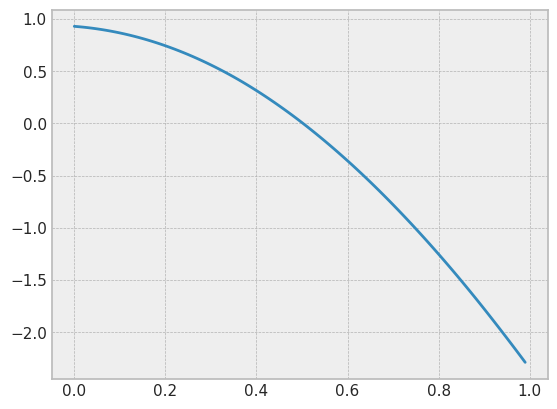

In [57]:
r2s = []
for cb in range(0, 100, 1) :
    predicted_y = discriminator(generator(X_test,cb/100))
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])

In [58]:
r2s

array([[ 0.        ,  0.92937849],
       [ 0.01      ,  0.92576015],
       [ 0.02      ,  0.92157368],
       [ 0.03      ,  0.91674081],
       [ 0.04      ,  0.91129575],
       [ 0.05      ,  0.90528654],
       [ 0.06      ,  0.89866961],
       [ 0.07      ,  0.89145095],
       [ 0.08      ,  0.8836538 ],
       [ 0.09      ,  0.87526923],
       [ 0.1       ,  0.86630808],
       [ 0.11      ,  0.85673902],
       [ 0.12      ,  0.8465684 ],
       [ 0.13      ,  0.83578136],
       [ 0.14      ,  0.82442671],
       [ 0.15      ,  0.8124603 ],
       [ 0.16      ,  0.79983729],
       [ 0.17      ,  0.78662488],
       [ 0.18      ,  0.77282939],
       [ 0.19      ,  0.75840839],
       [ 0.2       ,  0.74340841],
       [ 0.21      ,  0.72773004],
       [ 0.22      ,  0.7114498 ],
       [ 0.23      ,  0.69460742],
       [ 0.24      ,  0.67716332],
       [ 0.25      ,  0.65908288],
       [ 0.26      ,  0.64039457],
       [ 0.27      ,  0.62107738],
       [ 0.28      ,

## drift의 측정

+ 일단 생 y의 drift
+ reference 는 test dataset 200개
+ 따라서 bucket size = 200

Bucket size:200 step_size:190


 80%|████████  | 161/200 [00:00<00:00, 1609.60it/s]<ipython-input-10-160e0953fd26>:11: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
100%|██████████| 200/200 [00:00<00:00, 1606.08it/s]


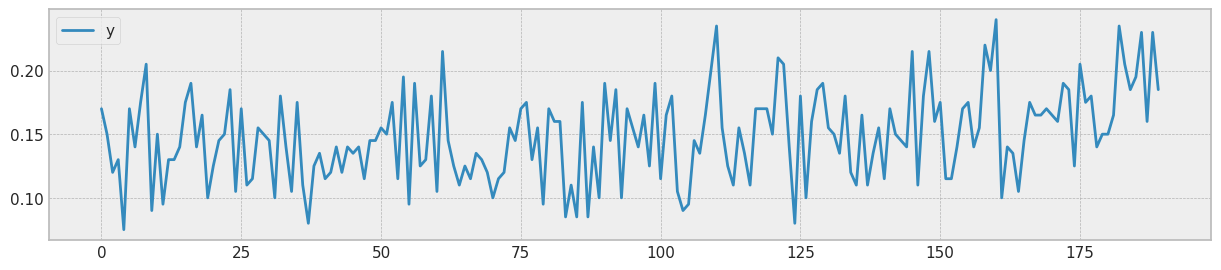

In [59]:

from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:

    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y = discriminator(generator(tx,0))
        ks = __ks_drift(y_test.reshape(-1,1),predicted_y.detach().numpy())
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()


+ z로 controll한 N개의 predicted_y의 drift
+ z값을 3개 대입한다. 
+ classification 처럼.... entropy를 사용한다.
+ 만약, z에 의해 조정된 N개 모델의 출력 y가 drift가 감지된다면 N개의 y값의 편차(?)가 증가하고 entropy 자체의 값이 증가하여야 한다. 

<Axes: >

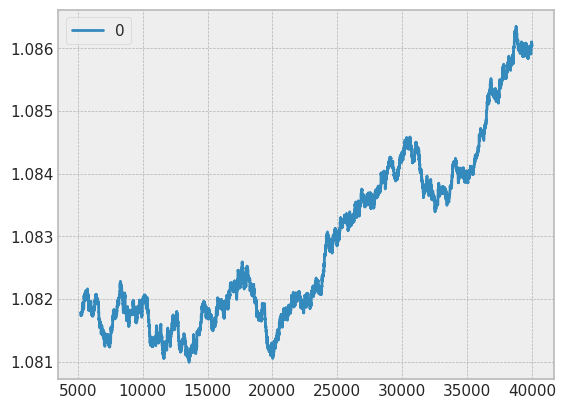

In [60]:
from scipy.stats import entropy
seed_everything()

r_gap = 0.05
ax = torch.tensor(x,dtype=torch.float32)
y1 = discriminator(generator(ax,0.0)).detach().numpy()
y2 = discriminator(generator(ax,r_gap)).detach().numpy()
y3 = discriminator(generator(ax,r_gap*2)).detach().numpy()
ay = np.concatenate((y1,y2,y3),1)
ye = entropy(ay,axis=1).reshape(-1,1)

ye_df = pd.DataFrame(ye)

# Replace infinite updated data with nan
ye_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
ye_df.dropna(inplace=True)

ye_df.rolling(window=5000).mean().plot()

In [61]:
from tqdm import tqdm
from scipy.stats import entropy

seed_everything()

r_gap = 0.05

bucket_size_array=[200] #[10,50,100,200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 237.12it/s]


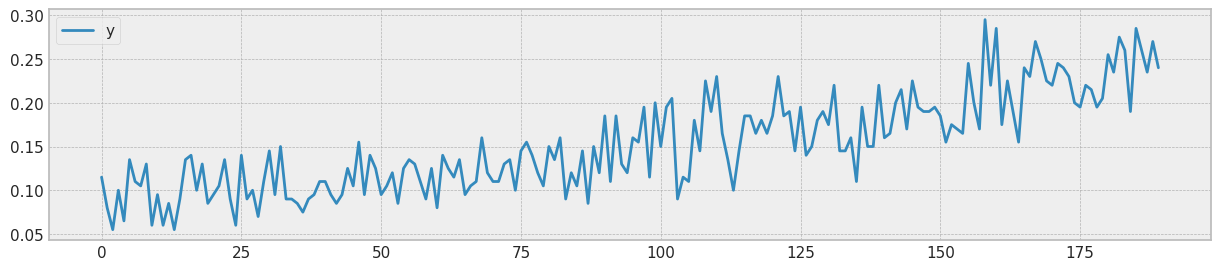

In [62]:
seed_everything()

for bucket_size in bucket_size_array:

    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y1 = discriminator(generator(tx,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tx,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tx,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## R2과 drift의 관계

+ Noise를 주어 Simulation 한다. -> 이 것을 z의 제어로 대처한다. 
+ r2, ks통계량의 그래프 그리기

100%|██████████| 10000/10000 [00:23<00:00, 419.73it/s]


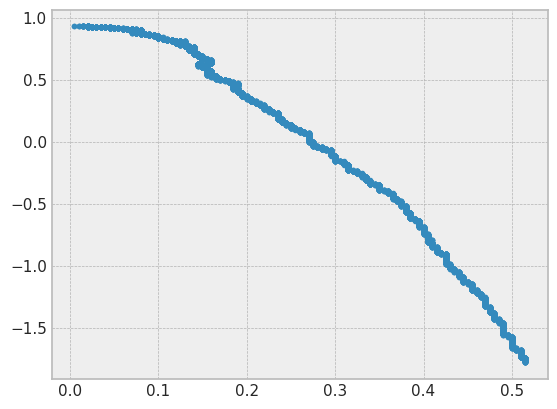

In [63]:
seed_everything()

simulation_count = 10000

sim = []

#tx = torch.tensor(X[0:2000].values, dtype=torch.float32)
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)

    sim.append([ks[0,0],r2])

sim = np.asarray(sim)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.')


## regression r2 predict model 학습

+ 상기 $R^2$ 과 Drfit 통계량의 상관관계를 학습하여, Drift 통계량을 통해 $R^2$를 예측하는 모델

In [64]:
# Define the regression model
class Regression_r2_predictor(nn.Module):
    
    def __init__(self):
        super(Regression_r2_predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output

In [65]:
from sklearn.model_selection import train_test_split

seed_everything()

train_drift, test_drift, train_r2, test_r2 = train_test_split(sim[:,0], sim[:,1], test_size=0.2)

train_drift = torch.tensor(train_drift,dtype=torch.float32)
test_drift = torch.tensor(test_drift,dtype=torch.float32)
train_r2 = torch.tensor(train_r2,dtype=torch.float32)
test_r2 = torch.tensor(test_r2,dtype=torch.float32)

100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


MSE: 0.01
RMSE: 0.07


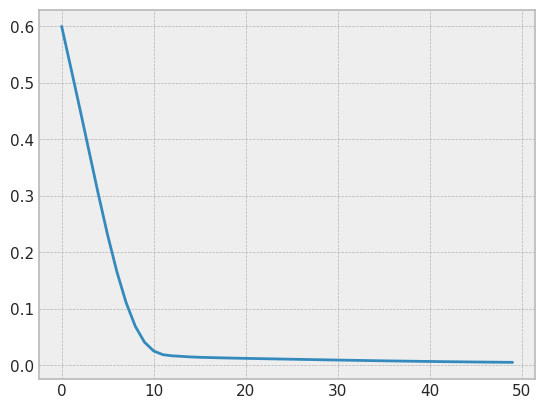

In [66]:
seed_everything()

r2_model = Regression_r2_predictor()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    r2_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_drift[start:start+batch_size].reshape(-1,1)
            y_batch = train_r2[start:start+batch_size].reshape(-1,1)
            # forward pass
            y_pred = r2_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    r2_model.eval()
    y_pred = r2_model(test_drift.reshape(-1,1))
    mse = loss_fn(y_pred.reshape(-1,1), test_r2.reshape(-1,1))
    mse = float(mse)
    history.append(mse)
 
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

In [67]:
# R2 예측의 성능
predicted_y = r2_model(test_drift.reshape(-1,1))
r2 = r2_score(test_r2,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9920294206504494


100%|██████████| 10000/10000 [00:14<00:00, 681.74it/s]
<ipython-input-68-85a91f74af31>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_r2s = np.asarray(pred_r2s)


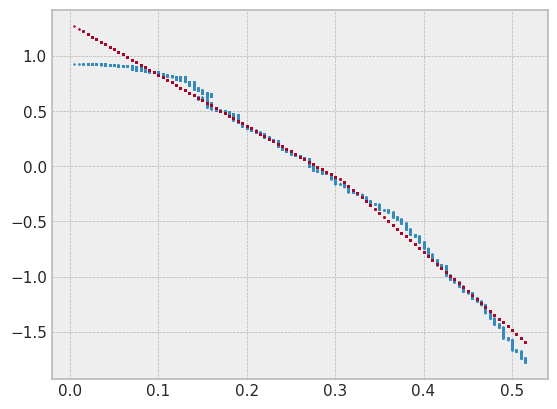

In [68]:
pred_r2s = []
for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)
    y_pred = r2_model(torch.tensor(ks[0,0].reshape(-1,1),dtype=torch.float32))
    pred_r2s.append([ks[0,0],y_pred.detach().numpy()])

pred_r2s = np.asarray(pred_r2s)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.',markersize=1)
plt.plot(pred_r2s[:,0],pred_r2s[:,1],'.',markersize=1)

## 성능 예측 모델의 새로운 설계

+ Deep learning이 아니라, 기본함수의 parameter를 학습 데이터에 fit하게 학습 시킨다. 
+ 기본 함수 : y = a * tanh(b*(x+c)) + e
+ 상기 함수에서 a,b,c,d,e 를 fit 한다.

In [69]:
# Define the regression model
class Regression_r2_predictor2(nn.Module):
    
    def __init__(self):
        super(Regression_r2_predictor2, self).__init__()
        # a,b,c,d,e 5개의 parameter를 fit 한다.
        self.model = nn.Sequential(
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 5)
        )

    def forward(self, input_data):
        fixed_in = torch.ones((1,10),dtype=torch.float32)
        o = self.model(fixed_in).reshape(5,-1)
        return self.func(input_data,o[0,0],o[1,0],o[2,0],o[3,0],o[4,0])

    def func(self,x,a,b,c,d,e):
        #print(a,b,c,d,e)
        y = a * torch.tanh(b*(x+c)) + e
        #y = a * (x+c) + e
        return y
    

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


MSE: 0.00
RMSE: 0.05


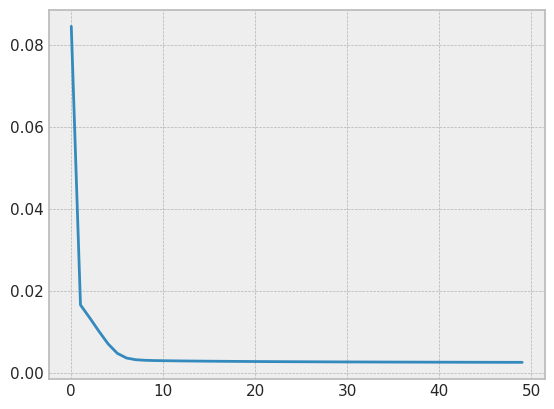

In [70]:
seed_everything()

r2_model = Regression_r2_predictor2()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    r2_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_drift[start:start+batch_size].reshape(-1,1)
            y_batch = train_r2[start:start+batch_size].reshape(-1,1)
            # forward pass
            y_pred = r2_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    r2_model.eval()
    y_pred = r2_model(test_drift.reshape(-1,1))
    mse = loss_fn(y_pred.reshape(-1,1), test_r2.reshape(-1,1))
    mse = float(mse)
    history.append(mse)
 
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

100%|██████████| 10000/10000 [00:15<00:00, 635.61it/s]
<ipython-input-71-85a91f74af31>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_r2s = np.asarray(pred_r2s)


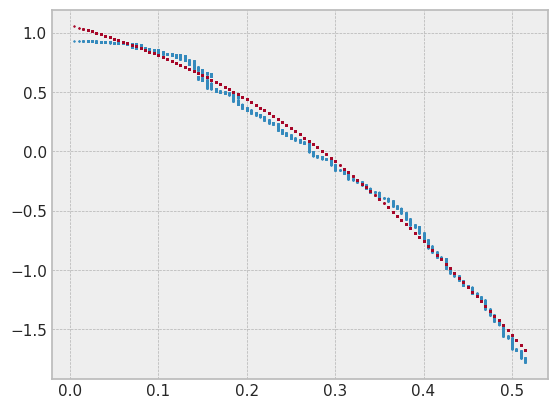

In [71]:
pred_r2s = []
for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)
    y_pred = r2_model(torch.tensor(ks[0,0].reshape(-1,1),dtype=torch.float32))
    pred_r2s.append([ks[0,0],y_pred.detach().numpy()])

pred_r2s = np.asarray(pred_r2s)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.',markersize=1)
plt.plot(pred_r2s[:,0],pred_r2s[:,1],'.',markersize=1)

## R2 예측의 적용

(38000,)
Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 609.25it/s]


<Axes: >

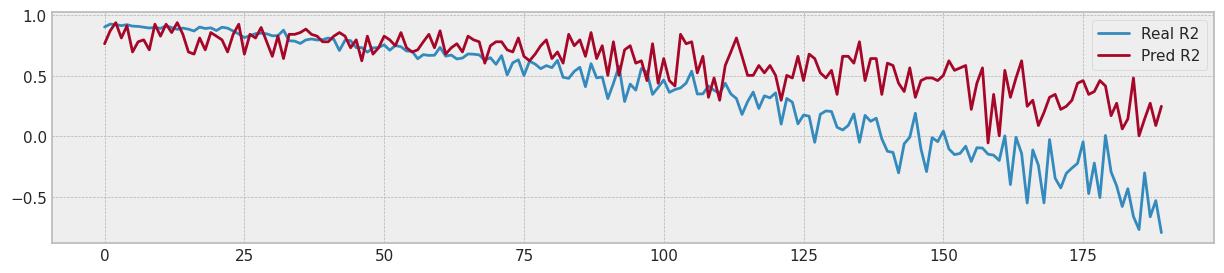

In [72]:
XT = X[2000:]
yT = y[2000:]

print(yT.shape)
bucket_size_array=[200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    print('Bucket size:%d step_size:%d'%(bucket_size,bucket_count))
    r2s = {}
    r2s['Real R2'] = []
    r2s['Pred R2'] = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)

        predicted_y1 = discriminator(generator(tmp_x,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tmp_x,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tmp_x,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = torch.tensor(__ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1)),dtype=torch.float32)
        predicted_r2 = r2_model(ks[:,0]).detach().numpy()[0]

        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y1)
        r2s['Real R2'].append(r2)
        r2s['Pred R2'].append(predicted_r2)


r2s_df = pd.DataFrame(r2s)
r2s_df.plot(figsize=(15,3))


+ 잘 안 맞음.
+ 대략의 추세정도만...
+ Bucket의 size를 늘려서 실험해 볼 필요 있을 듯. 

# 여기서 부터는 G 만 학습 시키는 경우의 실험

+ Generator에 control factor 'z' 를 대입하여, r2가 1~0 까지 전개되도록 학습한다.
+ Discriminator는 별도로 학습한다.

$$
L_{Discriminator}=mse(D(x),y) 
$$

$$
L_{Generator}=mse(G(x,z=0),x) - log(softmax(mse(G(x,z=1),x))) 
$$

  2%|▏         | 2/100 [00:00<00:17,  5.74it/s]

[Epoch 0/100] [L1 loss: 0.920388] [L2 loss: 4.011063] [A loss: 3.777755] [B loss: 0.233308]


 12%|█▏        | 12/100 [00:02<00:15,  5.71it/s]

[Epoch 10/100] [L1 loss: 0.327280] [L2 loss: 0.174960] [A loss: 0.164396] [B loss: 0.010565]


 21%|██        | 21/100 [00:04<00:18,  4.30it/s]

[Epoch 20/100] [L1 loss: 0.299352] [L2 loss: 0.052201] [A loss: 0.051568] [B loss: 0.000633]


 32%|███▏      | 32/100 [00:06<00:11,  5.83it/s]

[Epoch 30/100] [L1 loss: 0.285632] [L2 loss: 0.021493] [A loss: 0.021312] [B loss: 0.000181]


 42%|████▏     | 42/100 [00:07<00:09,  5.88it/s]

[Epoch 40/100] [L1 loss: 0.278200] [L2 loss: 0.006527] [A loss: 0.006463] [B loss: 0.000063]


 52%|█████▏    | 52/100 [00:09<00:08,  5.87it/s]

[Epoch 50/100] [L1 loss: 0.267381] [L2 loss: 0.002310] [A loss: 0.002283] [B loss: 0.000027]


 62%|██████▏   | 62/100 [00:11<00:06,  5.89it/s]

[Epoch 60/100] [L1 loss: 0.260583] [L2 loss: 0.001155] [A loss: 0.001140] [B loss: 0.000014]


 72%|███████▏  | 72/100 [00:13<00:04,  5.89it/s]

[Epoch 70/100] [L1 loss: 0.258163] [L2 loss: 0.000561] [A loss: 0.000552] [B loss: 0.000008]


 82%|████████▏ | 82/100 [00:14<00:03,  5.86it/s]

[Epoch 80/100] [L1 loss: 0.253673] [L2 loss: 0.000275] [A loss: 0.000269] [B loss: 0.000006]


 91%|█████████ | 91/100 [00:16<00:02,  4.25it/s]

[Epoch 90/100] [L1 loss: 0.249192] [L2 loss: 0.000225] [A loss: 0.000222] [B loss: 0.000004]


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


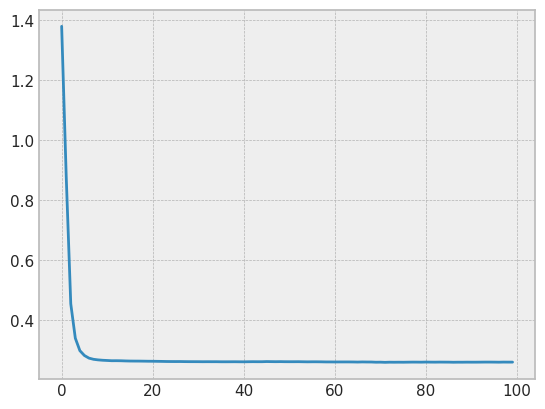

In [38]:
import copy
import torch.optim as optim

seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Initializes generator and discriminator
generator = Generator(5)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)

discriminator = Discriminator()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss function and optimizer
mse_loss = nn.MSELoss()  # mean square error
 
n_epochs = 100   # number of epochs to run
batch_size = 20  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            L1_loss = mse_loss(discriminator(X_batch), y_batch)

            #  Forword Generator for z=0 
            g0 = generator(X_batch,0)

            #  Forword Generator for z=1 
            g1 = generator(X_batch,1)

            a_loss = mse_loss(g0, X_batch)
            b_loss = -torch.log(torch.sigmoid(mse_loss(g1, X_batch)))*10

            L2_loss = a_loss + b_loss 

            # backward pass
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            L1_loss.backward()
            L2_loss.backward()
            # update weights
            optimizer_G.step()
            optimizer_D.step()    
            # print progress
            bar.set_postfix(mse=float(loss))


    if epoch % 10 == 0:
        print(
                "[Epoch %d/%d] [L1 loss: %f] [L2 loss: %f] [A loss: %f] [B loss: %f]"
                % (epoch, n_epochs, L1_loss, L2_loss, a_loss, b_loss)
            )
            
    # evaluate accuracy at end of each epoch
    generator.eval()
    discriminator.eval()
    
    y_pred = discriminator(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)

plt.plot(history)
plt.show()

+ Discriminator (Regression) 모델, 생짜의 성능 측정

In [39]:
# 순수 discriminator의 성능
predicted_y = discriminator(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9368178138622575


+ z=0 일때 상기 단일 생짜 모델과 성능 거의 유사

In [40]:
# z=0 일때 성능
predicted_y = discriminator(generator(X_test,0))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9367136228467181


+ z=1 일때 성능 바닦

In [41]:
# z=1 일때 성능
predicted_y = discriminator(generator(X_test,1))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score -0.31660146949607104


## z controllor 에 따른 R2 제어

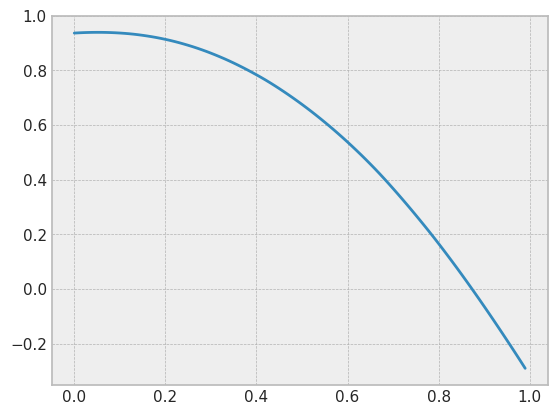

In [42]:
r2s = []
for cb in range(0, 100, 1) :
    predicted_y = discriminator(generator(X_test,cb/100))
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])

In [43]:
r2s

array([[ 0.        ,  0.93671362],
       [ 0.01      ,  0.93767088],
       [ 0.02      ,  0.93841018],
       [ 0.03      ,  0.93893145],
       [ 0.04      ,  0.9392947 ],
       [ 0.05      ,  0.93943141],
       [ 0.06      ,  0.93936317],
       [ 0.07      ,  0.93907359],
       [ 0.08      ,  0.93857943],
       [ 0.09      ,  0.93787261],
       [ 0.1       ,  0.93692234],
       [ 0.11      ,  0.93576643],
       [ 0.12      ,  0.93437633],
       [ 0.13      ,  0.9327151 ],
       [ 0.14      ,  0.93077142],
       [ 0.15      ,  0.92856614],
       [ 0.16      ,  0.92612684],
       [ 0.17      ,  0.92344013],
       [ 0.18      ,  0.92049285],
       [ 0.19      ,  0.91726852],
       [ 0.2       ,  0.91377206],
       [ 0.21      ,  0.91000778],
       [ 0.22      ,  0.90596311],
       [ 0.23      ,  0.90160649],
       [ 0.24      ,  0.89692509],
       [ 0.25      ,  0.8920461 ],
       [ 0.26      ,  0.88689627],
       [ 0.27      ,  0.88142563],
       [ 0.28      ,

<Axes: >

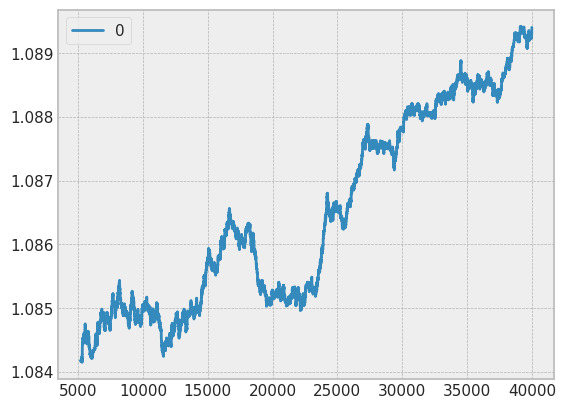

In [44]:
from scipy.stats import entropy
seed_everything()

r_gap = 0.05
ax = torch.tensor(x,dtype=torch.float32)
y1 = discriminator(generator(ax,0.0)).detach().numpy()
y2 = discriminator(generator(ax,r_gap)).detach().numpy()
y3 = discriminator(generator(ax,r_gap*2)).detach().numpy()
ay = np.concatenate((y1,y2,y3),1)
ye = entropy(ay,axis=1).reshape(-1,1)

ye_df = pd.DataFrame(ye)

# Replace infinite updated data with nan
ye_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
ye_df.dropna(inplace=True)

ye_df.rolling(window=5000).mean().plot()

## drift의 측정

Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 1048.02it/s]


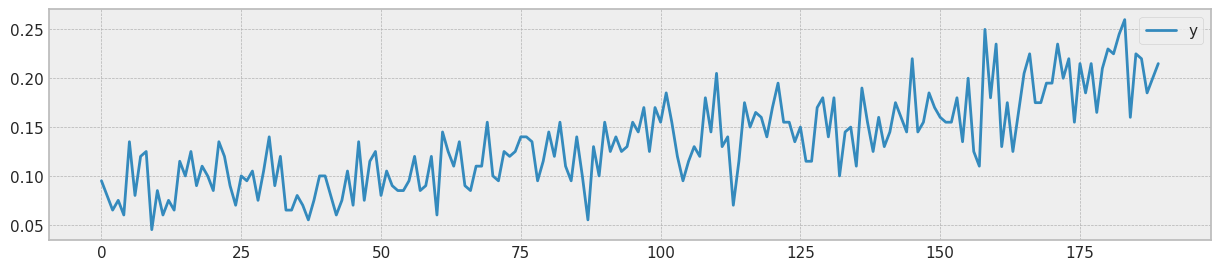

In [45]:
from tqdm import tqdm
from scipy.stats import entropy

seed_everything()

bucket_size_array=[200] #[10,50,100,200]
r_gap = 0.05
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:

    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y1 = discriminator(generator(tx,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tx,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tx,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## R2 vs. Drift

100%|██████████| 10000/10000 [00:13<00:00, 743.88it/s]


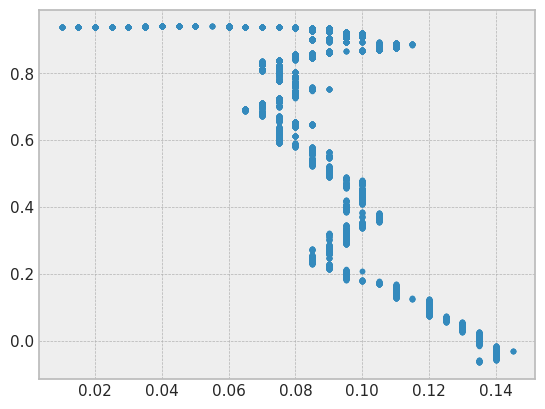

In [46]:
seed_everything()

simulation_count = 10000

sim = []

#tx = torch.tensor(X[0:2000].values, dtype=torch.float32)
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)

    sim.append([ks[0,0],r2])

sim = np.asarray(sim)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.')


## 성능 예측 모델

100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


MSE: 0.05
RMSE: 0.23


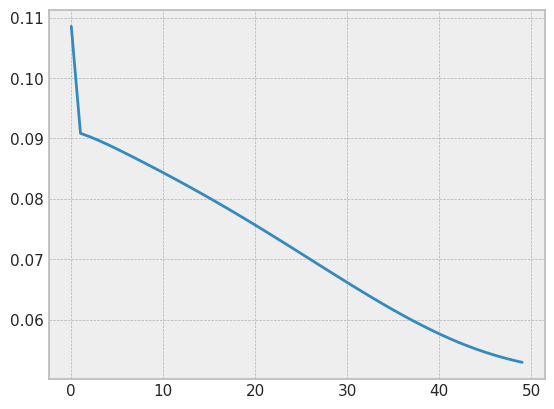

In [47]:
from sklearn.model_selection import train_test_split

seed_everything()

train_drift, test_drift, train_r2, test_r2 = train_test_split(sim[:,0], sim[:,1], test_size=0.2)

train_drift = torch.tensor(train_drift,dtype=torch.float32)
test_drift = torch.tensor(test_drift,dtype=torch.float32)
train_r2 = torch.tensor(train_r2,dtype=torch.float32)
test_r2 = torch.tensor(test_r2,dtype=torch.float32)


r2_model = Regression_r2_predictor()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    r2_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_drift[start:start+batch_size].reshape(-1,1)
            y_batch = train_r2[start:start+batch_size].reshape(-1,1)
            # forward pass
            y_pred = r2_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    r2_model.eval()
    y_pred = r2_model(test_drift.reshape(-1,1))
    mse = loss_fn(y_pred.reshape(-1,1), test_r2.reshape(-1,1))
    mse = float(mse)
    history.append(mse)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

In [48]:
# R2 예측의 성능
predicted_y = r2_model(test_drift.reshape(-1,1))
r2 = r2_score(test_r2,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.40687566193085445


100%|██████████| 10000/10000 [00:14<00:00, 672.58it/s]
<ipython-input-49-85a91f74af31>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_r2s = np.asarray(pred_r2s)


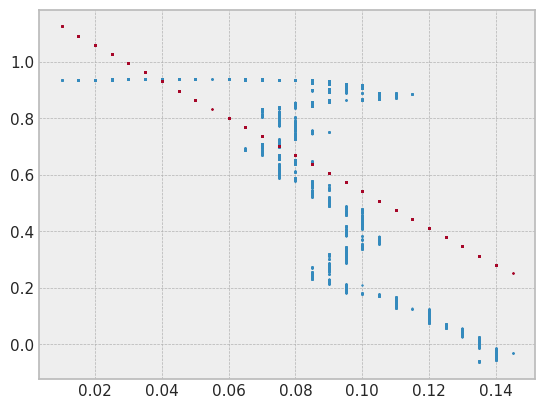

In [49]:
pred_r2s = []
for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)
    y_pred = r2_model(torch.tensor(ks[0,0].reshape(-1,1),dtype=torch.float32))
    pred_r2s.append([ks[0,0],y_pred.detach().numpy()])

pred_r2s = np.asarray(pred_r2s)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.',markersize=1)
plt.plot(pred_r2s[:,0],pred_r2s[:,1],'.',markersize=1)

In [50]:
torch.normal(mean=torch.ones(1, 100)*0.5, std=0.5)

tensor([[ 1.0202,  0.6296,  0.0946,  0.7612,  0.7645,  0.9504,  1.1531,  0.7963,
          0.3529,  0.2311, -0.0514,  0.6069,  0.1248,  1.0526,  0.5877,  1.1215,
          0.6720, -0.1637, -0.0833, -0.6703,  1.4746,  0.0250,  0.9450, -0.3694,
          0.6395,  0.7140, -0.5325,  0.2125,  0.4154,  0.5976,  0.5220,  0.9809,
          0.2916, -0.4751,  0.9341,  0.0968,  1.1135,  0.1020,  0.4014,  1.1695,
          0.1864,  1.2573,  1.0300,  0.4746, -0.1185,  0.6898,  0.2477,  0.4064,
          1.5194,  0.5279,  0.1177,  0.8279,  0.3930,  1.0203,  1.5682, -0.6621,
          1.3560,  0.3309,  0.3108, -0.8423,  0.3886,  0.2175,  0.2332, -0.1434,
          0.0046, -0.3204,  0.6181,  0.3387, -0.2315,  0.6750,  0.6835,  0.6068,
          0.9343,  0.3665, -0.2509,  1.4709,  0.9006,  1.1048, -0.6594,  0.0605,
          0.1280,  0.6471,  0.7568, -0.0639,  0.3769,  0.5461,  0.8360,  1.0851,
          1.1296,  0.8789,  0.4740, -0.3954,  1.0023, -0.0664,  0.9011,  0.7207,
          0.5199,  0.8888,  

100%|██████████| 10000/10000 [00:14<00:00, 705.90it/s]


MSE: 0.04
R-squared score 0.507675690831185


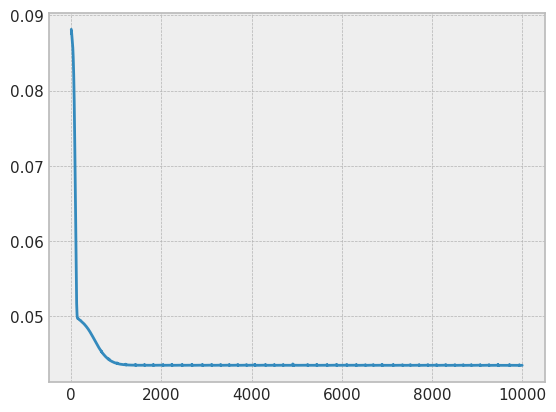

In [51]:
seed_everything()

input_dim = 100

# Define the regression model
class Regression_r2_predictor3(nn.Module):
    
    def __init__(self):
        super(Regression_r2_predictor3, self).__init__()
        # a,b,c,d,e 5개의 parameter를 fit 한다.
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, 5)     
        )

    def forward(self, input_data):
        #fixed_in = torch.normal(mean=torch.ones(1, input_dim)*0.5, std=1) #torch.ones((1,100),dtype=torch.float32)
        fixed_in = torch.ones((1,input_dim),dtype=torch.float32)
        o = self.model(fixed_in).reshape(5,-1)
        return self.func(input_data,o[0,0],o[1,0],o[2,0],o[3,0],o[4,0])

    def func(self,x,a,b,c,d,e):
        #print(a,b,c,d,e)
        #y = a * torch.tanh(-(100+b)*x + 50+c) - 0.5 + d
        y = a*torch.tanh(b*x + c) + d + 1
        #y = a * (x+c) + e
        return y

r2_model = Regression_r2_predictor3()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 10000   # number of epochs to run
#batch_size = 10  # size of each batch
#batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
#best_mse = np.inf   # init to infinity
#best_weights = None
history = []

r2_model.train()

for epoch in tqdm(range(n_epochs)):

    # forward pass
    y_pred = r2_model(train_drift)
    loss = loss_fn(y_pred, train_r2)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    # update weights
    optimizer.step()

    history.append(loss.detach().numpy())
 
print("MSE: %.2f" % loss)

# R2 예측의 성능
predicted_y = r2_model(test_drift.reshape(-1,1))
r2 = r2_score(test_r2,predicted_y.detach().numpy())
print('R-squared score',r2)

plt.plot(history)
plt.show()

100%|██████████| 10000/10000 [00:16<00:00, 610.38it/s]
<ipython-input-52-85a91f74af31>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_r2s = np.asarray(pred_r2s)


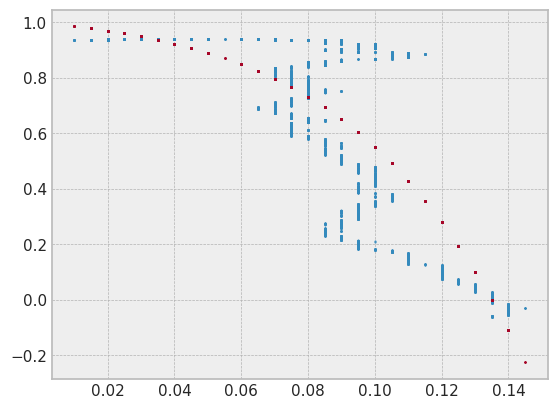

In [52]:
pred_r2s = []
for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=1-r_gap*2)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)
    y_pred = r2_model(torch.tensor(ks[0,0].reshape(-1,1),dtype=torch.float32))
    pred_r2s.append([ks[0,0],y_pred.detach().numpy()])

pred_r2s = np.asarray(pred_r2s)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.',markersize=1)
plt.plot(pred_r2s[:,0],pred_r2s[:,1],'.',markersize=1)

## 성능 예측

Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 592.24it/s]


<Axes: >

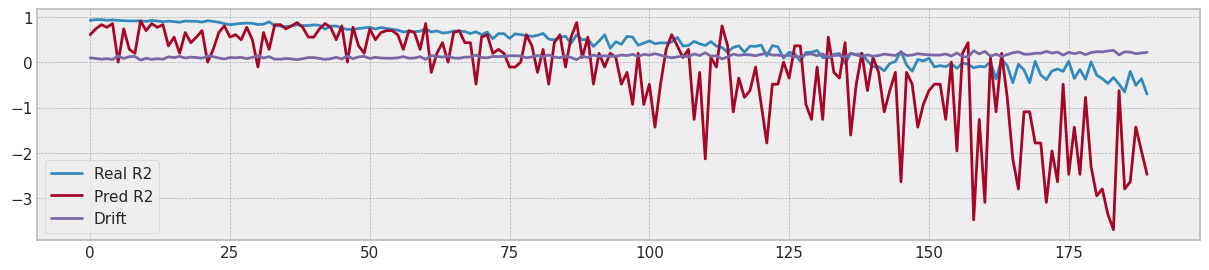

In [53]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    print('Bucket size:%d step_size:%d'%(bucket_size,bucket_count))
    r2s = {}
    r2s['Real R2'] = []
    r2s['Pred R2'] = []
    r2s['Drift'] = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)

        predicted_y1 = discriminator(generator(tmp_x,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tmp_x,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tmp_x,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = torch.tensor(__ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1)),dtype=torch.float32)
        dr = ks[:,0]
        predicted_r2 = r2_model(dr).detach().numpy()[0]

        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y1)
        r2s['Real R2'].append(r2)
        r2s['Pred R2'].append(predicted_r2)
        r2s['Drift'].append(dr.detach().numpy()[0])


r2s_df = pd.DataFrame(r2s)
r2s_df.plot(figsize=(15,3))


+ 개망함!
+ 역시, 성능 예측은 잘 안맞음...
+ r_gap의 최적화, entropy 가 아닌 다른 개념의 적용 등. 응용 실험할 Case는 다수 있을 듯

# VAE 를 적용하여 Generator 만들기

참조 : https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py

+ 일단, 위의 synthetic data로 Tabular data를 생성해 본다

In [173]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch import distributions

class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma)
        return torch.distributions.Normal(loc=mu, scale=sigma)


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu = torch.tanh(self.linear2(x))
        return torch.distributions.Normal(mu, torch.ones_like(mu))

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state):
        q_z = self.encoder(state)
        z = q_z.rsample()
        return self.decoder(z), q_z


Number of samples:  1800


100%|██████████| 3000/3000 [00:11<00:00, 251.00it/s]


2999 23.09404754638672 -22.32164764404297 0.7724002003669739


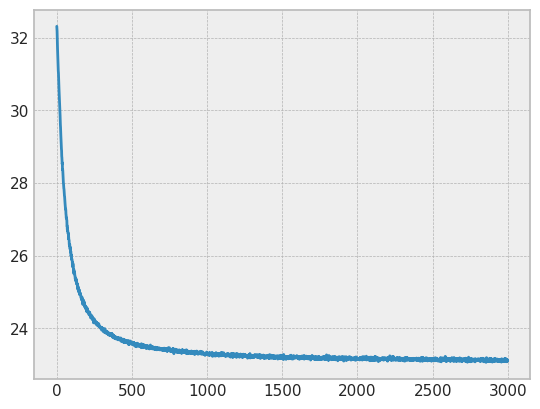

In [188]:
seed_everything()

input_dim = 5
batch_size = 400
num_epochs = 3000
learning_rate = 0.001
hidden_size = 20
latent_size = 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Number of samples: ', len(X_train))

encoder = Encoder(input_dim, hidden_size, latent_size)
decoder = Decoder(latent_size, hidden_size, input_dim)

vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
losses = []
X_train = X_train.to(device)
for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()
    p_x, q_z = vae(X_train)
    log_likelihood = p_x.log_prob(X_train).sum(-1).mean()
    kl = torch.distributions.kl_divergence(
        q_z, 
        torch.distributions.Normal(0, 1.)
    ).sum(-1).mean()
    loss = -(log_likelihood - kl)
    loss.backward()
    optimizer.step()
    l = loss.item()
    losses.append(l)

print('')
print(epoch, l, log_likelihood.item(), kl.item())

plt.plot(losses)

+ X_test를 통해 가상으로 생성된 data

In [189]:
X_test = X_test.to(device)
p_x, q_z = vae(X_test)

In [190]:
syn_data = p_x.loc[:].cpu().detach().numpy()

array([[ 0.99996173,  0.9999926 ,  0.999998  ,  0.9999971 ,  0.99998754],
       [ 0.99965984,  0.99994534,  0.99998   ,  0.9999647 ,  0.99993396],
       [ 0.99990684,  0.99998575,  0.9999946 ,  0.99999267,  0.9999768 ],
       [ 0.9999743 ,  0.99999493,  0.9999986 ,  0.9999982 ,  0.99999094],
       [-0.9999996 , -0.5659627 , -0.44318166, -0.28689727, -0.29637545],
       [ 0.9999889 ,  0.99999714,  0.9999995 ,  0.999999  ,  0.9999949 ],
       [ 0.99999756,  0.9999993 ,  0.9999999 ,  0.9999998 ,  0.99999845],
       [ 0.99998313,  0.9999962 ,  0.9999992 ,  0.9999986 ,  0.99999315],
       [ 0.9938148 ,  0.99926734,  0.99968576,  0.99946564,  0.99934536],
       [ 0.9955313 ,  0.9997404 ,  0.9998263 ,  0.9997158 ,  0.9996858 ],
       [ 0.99997896,  0.99999523,  0.999999  ,  0.9999982 ,  0.99999183],
       [ 0.9999996 ,  0.9999998 ,  1.        ,  1.        ,  0.9999996 ],
       [-1.        , -0.89399743, -0.8514914 , -0.7543969 , -0.76290214],
       [ 0.99984664,  0.9999682 ,  0.9

TypeError: ignored

+ 여기서, VAE의 std에 controller z를 넣어서, 가상 생성 data의 흐트리는 정도를 조정할 수 있도록 한다.
+ encoder에서 sigma + z를 한다.

In [177]:
class Encoder2(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder2, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x, z):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma) + z
        return torch.distributions.Normal(loc=mu, scale=sigma)

 
class VAE2(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, state, z):
        q_z = self.encoder(state,z)
        z = q_z.rsample()
        return self.decoder(z), q_z       

Number of samples:  1800


100%|██████████| 3000/3000 [00:12<00:00, 239.63it/s]


2999 23.085693359375 -22.2967586517334 0.7889355421066284


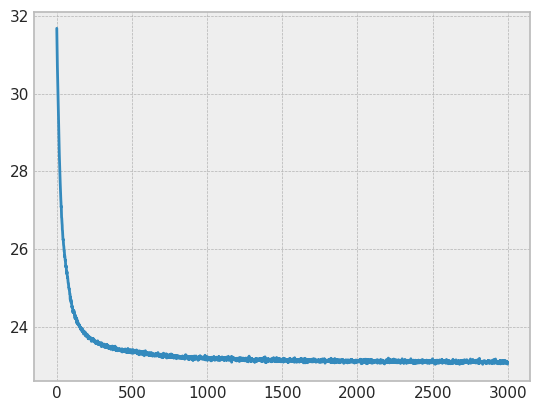

In [178]:
seed_everything()

input_dim = 5
batch_size = 400
num_epochs = 3000
learning_rate = 0.001
hidden_size = 50
latent_size = 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Number of samples: ', len(X_train))

encoder = Encoder2(input_dim, hidden_size, latent_size)
decoder = Decoder(latent_size, hidden_size, input_dim)

vae = VAE2(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
losses = []
X_train = X_train.to(device)
for epoch in tqdm(range(num_epochs)):

    optimizer.zero_grad()
    p_x, q_z = vae(X_train,0)
    log_likelihood = p_x.log_prob(X_train).sum(-1).mean()
    kl = torch.distributions.kl_divergence(
        q_z, 
        torch.distributions.Normal(0, 1.)
    ).sum(-1).mean()
    loss = -(log_likelihood - kl)
    loss.backward()
    optimizer.step()
    l = loss.item()
    losses.append(l)

print('')
print(epoch, l, log_likelihood.item(), kl.item())

plt.plot(losses)

In [179]:
np.mean(np.std(X_test.cpu().detach().numpy(),1))

1.3501654

In [182]:
X_test = X_test.to(device)
# z=0 일때
p_x, q_z = vae(X_test,0)
syn_data = p_x.loc[:].cpu().detach().numpy()
np.mean(np.std(syn_data,1))

0.099817

In [183]:
X_test = X_test.to(device)
# z=1 일때
p_x, q_z = vae(X_test,1)
syn_data = p_x.loc[:].cpu().detach().numpy()
np.mean(np.std(syn_data,1))

0.122606345

In [186]:
X_test = X_test.to(device)
# z=2 일때
p_x, q_z = vae(X_test,2)
syn_data = p_x.loc[:].cpu().detach().numpy()
np.mean(np.std(syn_data,1))

0.08527881

## controller z에 따른 R2의 제어

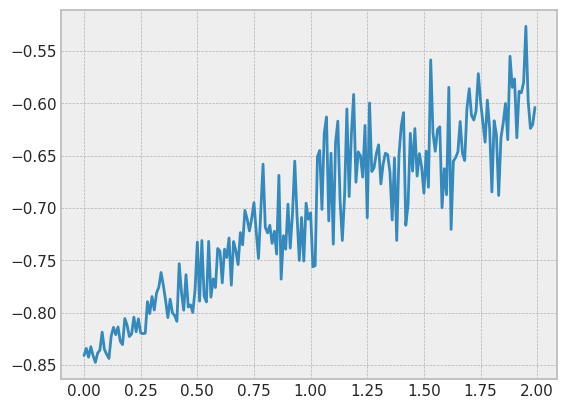

In [187]:
r2s = []
for cb in range(0, 200, 1) :
    p_x, q_z = vae(X_test,cb/100)
    syn_data = p_x.loc[:].cpu().detach().numpy()
    syn_data = torch.tensor(syn_data,dtype=torch.float32)
    predicted_y = discriminator(syn_data)
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])